In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Conv2DTranspose
from scipy.interpolate import RectBivariateSpline
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Boundary import Boundary1D
from collections.abc import Iterable
import itertools, h5py
from multiprocessing import Pool as ThreadPool
opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
conf = tf.ConfigProto(gpu_options=opts)
tfe.enable_eager_execution(config=conf)

In [2]:
def poisson_matrix(m,n):
    '''
    Generates the matrix A to express the Poisson equation in the form Ax=b for an m-by-n grid
    
    Them matrix returned shall be (m-2)*(n-2)-by-(m-2)*(n-2) in size
    
    CURRENTLY ONLY WORKS FOR SQUARE DOMAINS!!!!
    '''
    m = m-2
    n = n-2
    
    D = np.zeros((m,m), dtype = np.float64)
    i,j = np.indices(D.shape)
    D[i==j] = 4.0
    D[i==j-1] = -1.0
    D[i==j+1] = -1.0
    
    S = -np.eye(D.shape[0], dtype = np.float64)
    
    P = np.zeros((m*n,m*n), dtype = np.float64)
    ind = np.arange(0,m*(n+1), m)
    
    for i in range(len(ind)-1):
        P[ind[i]:ind[i+1], ind[i]:ind[i+1]] = D
        try:
            P[ind[i+1]:ind[i+2], ind[i]:ind[i+1]] = S
        except:
            pass
        try:
            P[ind[i-1]:ind[i], ind[i]:ind[i+1]] = S
        except:
            pass
    return P

def generate_random_RHS(n, n_controlpts = None, n_outputpts = None, s = 5, domain = [0,1,0,1]):
    
    '''
    This function generates random smooth RHS 'functions' defined pointwise using bivariate splines. 
    n: no. of random RHSes to generate
    n_controlpts: no. of control pts of the spline. Smaller values lead to 'smoother' results
    n_outputpts: no. of gridpoints in each direction of the output 
    s: see parameter s in scipy.interpolate.RectBivariateSpline
    domain: [x_min, x_max, y_min, y_max]
    '''
    
    
    if isinstance(n, Iterable):
        n_controlpts = n[1]
        n_outputpts = n[2]
        try:
            s = n[3]
        except:
            pass
        try:
            domain = n[4]
        except:
            pass
        n = n[0]
    
    x = np.linspace(domain[0], domain[1], n_controlpts)
    y = np.linspace(domain[2], domain[3], n_controlpts)
    if n_controlpts != n_outputpts:
        x_out = np.linspace(domain[0], domain[1], n_outputpts)
        y_out = np.linspace(domain[2], domain[3], n_outputpts)
    else:
        x_out = x
        y_out = y
            
    out = []
    for i in range(n):
        spl = RectBivariateSpline(x,y,np.random.rand(len(x), len(y)), s=s)
        out.append(spl(x_out,y_out))
    return np.array(out)
    

def poisson_RHS(F, boundaries = None, h = None):
    '''
    Generates the RHS vector b of a discretized Poisson problem in the form Ax=b.
    h = grid spacing
    boundaries = dict containing entries 'top', 'bottom', 'right' and 'left' which correspond to the Dirichlet BCs at these boundaries. Each entry must be a vector of length m or n, where m and n are defined as in te function poisson_matrix
    F = an m by n matrix containing the RHS values of the Poisson equation
    '''
    
    if isinstance(F, Iterable):
        boundaries = F[1]
        h = F[2]
        F = F[0]
    
    F = -h**2 * F
    F[...,1:-1,1] = F[...,1:-1,1] + np.array(boundaries['top'])[1:-1]
    F[...,1:-1,-2] = F[...,1:-1,-2] + np.array(boundaries['bottom'])[1:-1]
    F[...,1,1:-1] = F[...,1,1:-1] + np.array(boundaries['left'])[1:-1]
    F[...,-2,1:-1] = F[...,-2,1:-1] + np.array(boundaries['right'])[1:-1]
    
    return F[...,1:-1,1:-1].reshape(list(F[...,1:-1,1:-1].shape[:-2]) + [np.prod(F[...,1:-1,1:-1].shape[-2:])])
 
def generate_dataset(batch_size, n, h, boundaries, n_batches = 1, rhs_range = [-1,1]):
    lhs = tf.constant(poisson_matrix(n,n), dtype=tf.float64)
    lhs_chol = tf.linalg.cholesky(lhs)
    
    def chol(r):
        return tf.linalg.cholesky_solve(lhs_chol, tf.transpose(tf.stack([r])))
    
    @tf.contrib.eager.defun
    def chol_solve(rhs_arr):
        return tf.map_fn(chol, rhs)
    
    #pdb.set_trace()
    pool = ThreadPool(n_batches)
    F = pool.map(generate_random_RHS, zip(itertools.repeat(batch_size, n_batches), itertools.repeat(10), itertools.repeat(n), itertools.repeat(5), itertools.repeat([0,n*h,0,n*h])))
    rhs = tf.concat(pool.map(poisson_RHS, zip(F, itertools.repeat(boundaries), itertools.repeat(h))), axis=0)
    
    soln = np.zeros((n_batches * batch_size, n, n), dtype = np.float64)
    soln[...,:,0] = boundaries['top']
    soln[...,:,-1] = boundaries['bottom']
    soln[...,0,:] = boundaries['left']
    soln[...,-1,:] = boundaries['right']
    soln[:,1:-1,1:-1] = tf.reshape(chol_solve(rhs), (n_batches * batch_size, n-2, n-2))
    #soln = chol_solve(rhs)
    
    #return tf.reshape(soln, (n_batches, batch_size, lhs_chol.shape[0])), tf.reshape(F, (n_batches, batch_size, F.shape[-2], F.shape[-1]))
    return tf.reshape(soln, (n_batches*batch_size, 1, soln.shape[-2], soln.shape[-1])), tf.reshape(tf.concat(F, axis = 0), (n_batches*batch_size, 1, F[0].shape[-2], F[0].shape[-1]))


In [ ]:
ntest = 64
h = 0.05
boundary_top = Boundary1D('Dirichlet', [(0,ntest*h),(ntest*h,ntest*h)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_right = Boundary1D('Dirichlet', [(ntest*h,ntest*h),(ntest*h,0)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_bottom = Boundary1D('Dirichlet', [(ntest*h,0),(0,0)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)
boundary_left = Boundary1D('Dirichlet', [(0,0),(0,ntest*h)], orientation='clockwise', RHS_function=lambda t: t-t, boundary_rhs_is_parametric=True)

In [ ]:
import time
t0 = time.time()
soln,F = generate_dataset(batch_size=2000, n = ntest, h = h, n_batches=20, boundaries={'top': boundary_top.RHS_evaluate(np.linspace(boundary_top.t.min(),boundary_top.t.max(),ntest)), 'right': boundary_right.RHS_evaluate(np.linspace(boundary_right.t.min(),boundary_right.t.max(),ntest)), 'bottom': boundary_bottom.RHS_evaluate(np.linspace(boundary_bottom.t.min(),boundary_bottom.t.max(),ntest)), 'left': boundary_left.RHS_evaluate(np.linspace(boundary_left.t.min(),boundary_left.t.max(),ntest))})
t1 = time.time()
print('Generation of training data took ' + str(t1-t0) + ' seconds')
with h5py.File('dataset.h5', 'w') as hf:
    hf.create_dataset('soln', data=soln)
    hf.create_dataset('F', data=F)

In [ ]:
with h5py.File('dataset.h5', 'r') as hf:
    F = tf.constant(hf.get('F'))
    soln = tf.constant(hf.get('soln'))

In [ ]:
i = np.random.randint(1,ntest-2)
j = np.random.randint(1,ntest-2)
p = np.random.randint(0,soln.shape[0]-1)
print((-4 * soln[p,0,i,j] + soln[p,0,i,j-1] + soln[p,0,i-1,j] + soln[p,0,i+1,j] + soln[p,0,i,j+1])/(h**2))
print(F[p,0,i,j])
print(soln[p,0,i,j])

In [ ]:
shuffle_size = 100000
batch_size = 1000
dataset = tf.data.Dataset.from_tensor_slices((F,soln)).shuffle(shuffle_size).batch(batch_size)

In [7]:
input0 = Input(shape=(1,ntest,ntest,))
conv1 = Conv2D(filters = 256, kernel_size = 8, strides=4, activation=tf.nn.relu, data_format='channels_first', padding='same')(input0)
conv2 = Conv2D(filters = 512, kernel_size = 4, strides=2, activation=tf.nn.relu, data_format='channels_first', padding='same')(conv1)
conv3 = Conv2D(filters = 1024, kernel_size = 2, strides=2, activation=tf.nn.relu, data_format='channels_first', padding='same')(conv2)
deconv1 = Conv2DTranspose(filters = 512, kernel_size = 2, strides = 2, activation=tf.nn.relu, data_format='channels_first', padding='same')(conv3)
deconv2 = Conv2DTranspose(filters = 256, kernel_size = 4, strides = 2, activation=tf.nn.relu, data_format='channels_first', padding='same')(deconv1)
deconv3 = Conv2DTranspose(filters = 1, kernel_size = 8, strides = 4, activation=tf.nn.tanh, data_format='channels_first', padding='same')(deconv2)

In [8]:
a = Model(input0,deconv3)
a.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-5), loss = tf.losses.huber_loss, metrics = ['accuracy'])
a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 64, 64)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 16, 16)       16640     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 8, 8)         2097664   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 4, 4)        2098176   
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 512, 8, 8)         2097664   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 256, 16, 16)       2097408   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 1, 64, 64)         16385     
Total para

In [64]:
epochs = 5
for epoch in range(epochs):
    for (batch, (inputs, labels)) in enumerate(dataset):
        loss, accuracy = a.train_on_batch(inputs,labels)
        
        if batch%10 == 0:
            print(batch, accuracy)

0 0.01553125
10 0.015171875
0 0.015875
10 0.016015625
0 0.015046875
10 0.014765625
0 0.016296875
10 0.01603125
0 0.0158125
10 0.015328125


In [9]:
a.fit(dataset, steps_per_epoch=4, epochs=5)

Epoch 1/5
4/4 [==============================] - 13s 3s/step - loss: 1.7747e-05 - acc: 0.0150
Epoch 2/5
4/4 [==============================] - 7s 2s/step - loss: 1.7521e-05 - acc: 0.0155
Epoch 3/5
4/4 [==============================] - 7s 2s/step - loss: 1.8146e-05 - acc: 0.0151
Epoch 4/5
4/4 [==============================] - 7s 2s/step - loss: 1.7503e-05 - acc: 0.0149
Epoch 5/5
4/4 [==============================] - 7s 2s/step - loss: 1.8085e-05 - acc: 0.0147


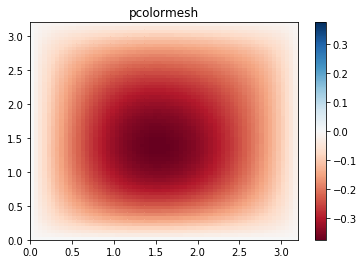

In [21]:
y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
#z = a.predict(tf.expand_dims(F[0,...], axis=0))[0,0,...]
z = soln[3,0,...]
#z = generate_random_RHS(10, n_controlpts=10, n_outputpts=64)[4,:,:]
#z = a.predict(tf.expand_dims(F[0,...], axis=0))[0,0,...] - soln[0,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

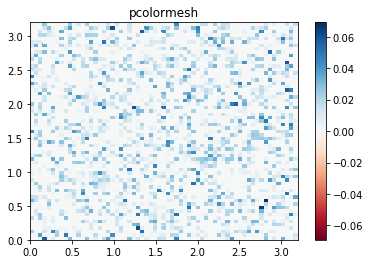

In [14]:
# y, x = np.meshgrid(np.linspace(0, ntest*h, num=ntest), np.linspace(0, ntest*h, num=ntest))
# z = tf.reshape(a.predict(tf.expand_dims(F[0,...], axis=0))[0,...], (ntest,ntest))
# #z = tf.reshape(soln[0,...], (ntest, ntest))
# #z = a.predict(tf.expand_dims(F[0,...], axis=0))[0,0,...] - soln[0,0,...]
# z_min, z_max = -np.abs(z).max(), np.abs(z).max()
# fig, ax = plt.subplots()
# c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
# ax.set_title('pcolormesh')
# ax.axis([x.min(), x.max(), y.min(), y.max()])
# fig.colorbar(c, ax=ax)

# plt.show()

In [63]:
print(s.shape)

(1000, 1, 64, 64)


In [65]:
tf.losses.mean_squared_error(F[0,...], s)

<tf.Tensor: id=24319, shape=(), dtype=float32, numpy=0.33316737>

In [79]:
a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1, 64, 64)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 256, 16, 16)       16640     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 512, 8, 8)         2097664   
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1024, 4, 4)        2098176   
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 512, 8, 8)         2097664   
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 256, 16, 16)       2097408   
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 1, 64, 64)         16385     
Total para

In [12]:
F.shape

TensorShape([Dimension(10000), Dimension(4096)])

In [11]:
soln.shape

TensorShape([Dimension(10000), Dimension(4096)])

In [36]:
np.max(F[0,0,...])

0.9995546650716034

In [107]:
dataset.output_shapes

(TensorShape([Dimension(None), Dimension(1), Dimension(64), Dimension(64)]),
 TensorShape([Dimension(None), Dimension(1), Dimension(64), Dimension(64)]))

In [4]:
generate_random_RHS(10, n_controlpts=10, n_outputpts=64).shape

(10, 64, 64)

In [ ]:
pool = ThreadPool(3)
F = pool.map(generate_random_RHS, zip(itertools.repeat(4), itertools.repeat(10), itertools.repeat(ntest), itertools.repeat(5), itertools.repeat([0,ntest*h,0,ntest*h])))